In [2]:
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl

    100% |████████████████████████████████| 592.3MB 47.6MB/s 


In [3]:
!pip3 install torchvision

    100% |████████████████████████████████| 61kB 5.9MB/s 
    100% |████████████████████████████████| 2.0MB 11.0MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import nltk
import random
import numpy as np
from collections import Counter, OrderedDict
import nltk
from copy import deepcopy
import os
import re
import unicodedata
flatten = lambda l: [item for sublist in l for item in sublist]

from torch.nn.utils.rnn import PackedSequence,pack_padded_sequence
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
random.seed(1024)
%matplotlib inline

In [0]:
USE_CUDA = torch.cuda.is_available()
gpus = [0]
torch.cuda.set_device(gpus[0])

FloatTensor = torch.cuda.FloatTensor if USE_CUDA else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if USE_CUDA else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if USE_CUDA else torch.ByteTensor

In [0]:
def getBatch(batch_size, train_data):
    random.shuffle(train_data)
    sindex=0
    eindex=batch_size
    while eindex < len(train_data):
        batch = train_data[sindex: eindex]
        temp = eindex
        eindex = eindex + batch_size
        sindex = temp
        yield batch
    
    if eindex >= len(train_data):
        batch = train_data[sindex:]
        yield batch

In [0]:
def pad_to_batch(batch, x_to_ix, y_to_ix):
    
    sorted_batch =  sorted(batch, key=lambda b:b[0].size(1), reverse=True) # sort by len
    x,y = list(zip(*sorted_batch))
    max_x = max([s.size(1) for s in x])
    max_y = max([s.size(1) for s in y])
    x_p, y_p = [], []
    for i in range(len(batch)):
        if x[i].size(1) < max_x:
            x_p.append(torch.cat([x[i], Variable(LongTensor([x_to_ix['<PAD>']] * (max_x - x[i].size(1)))).view(1, -1)], 1))
        else:
            x_p.append(x[i])
        if y[i].size(1) < max_y:
            y_p.append(torch.cat([y[i], Variable(LongTensor([y_to_ix['<PAD>']] * (max_y - y[i].size(1)))).view(1, -1)], 1))
        else:
            y_p.append(y[i])
        
    input_var = torch.cat(x_p)
    target_var = torch.cat(y_p)
    input_len = [list(map(lambda s: s ==0, t.data)).count(False) for t in input_var]
    target_len = [list(map(lambda s: s ==0, t.data)).count(False) for t in target_var]
    
    return input_var, target_var, input_len, target_len

In [0]:
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalize_string(s):
    s = unicode_to_ascii(s.lower().strip())
    s = re.sub(r"([,.!?])", r" \1 ", s)
    s = re.sub(r"[^a-zA-Z,.!?]+", r" ", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s

In [0]:
corpus = open('fra.txt', 'r', encoding='utf-8').readlines()
corpus = corpus[:30000]

In [0]:
MIN_LENGTH = 3
MAX_LENGTH = 25

In [11]:
X_r, y_r = [], [] # raw

for parallel in corpus:
    so,ta = parallel[:-1].split('\t')
    if so.strip() == "" or ta.strip() == "": 
        continue
    
    normalized_so = normalize_string(so).split()
    normalized_ta = normalize_string(ta).split()
    
    if len(normalized_so) >= MIN_LENGTH and len(normalized_so) <= MAX_LENGTH \
    and len(normalized_ta) >= MIN_LENGTH and len(normalized_ta) <= MAX_LENGTH:
        X_r.append(normalized_so)
        y_r.append(normalized_ta)
    

print(len(X_r), len(y_r))
print(X_r[0], y_r[0])

29807 29807
['i', 'see', '.'] ['je', 'comprends', '.']


In [12]:
print(X_r[1], y_r[1])

['i', 'try', '.'] ['j', 'essaye', '.']


In [13]:
#Building vocabulary
source_vocab = list(set(flatten(X_r)))
target_vocab = list(set(flatten(y_r)))
print(len(source_vocab))
print(len(target_vocab))

4443
7664


In [0]:
source_to_index = {"<PAD>":0, "<UNK>":1, "<s>":2, "</s>":3}
for word in source_vocab:
    if(word not in source_to_index):
        source_to_index[word]=len(source_to_index)
index_to_source = {v:k for k, v in source_to_index.items()}

target_to_index = {"<PAD>":0, "<UNK>":1, "<s>":2, "</s>":3}
for word in target_vocab:
    if(word not in target_to_index):
        target_to_index[word]=len(target_to_index)
index_to_target = {v:k for k, v in target_to_index.items()}

In [0]:
def prepare_sequence(seq, to_index):
    idxs = list(map(lambda w: to_index[w] if to_index.get(w) is not None else to_index["<UNK>"], seq))
    return Variable(LongTensor(idxs))

In [0]:
X_p, y_p = [], []

for so, ta in zip(X_r, y_r):
    X_p.append(prepare_sequence(so + ['</s>'], source_to_index).view(1, -1))
    y_p.append(prepare_sequence(ta + ['</s>'], target_to_index).view(1, -1))
    
train_data = list(zip(X_p, y_p))

In [17]:
print(X_p[10000],y_p[10000])

Variable containing:
 2948  4301  2660  2620  3972     3
[torch.cuda.LongTensor of size 1x6 (GPU 0)]
 Variable containing:
  992  2207   565  5234   642   897  6095  3670     3
[torch.cuda.LongTensor of size 1x9 (GPU 0)]



In [0]:
#Encoder
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, n_layers=1, bidirec=False):
        super(Encoder, self).__init__()
        self.input_size=input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.embedding = nn.Embedding(input_size, embedding_size)
        
        if (bidirec == False):
            self.n_direction=1
            self.gru=nn.GRU(embedding_size, hidden_size, n_layers, batch_first=True)
        else:
            self.n_direction=2
            self.gru=nn.GRU(embedding_size, hidden_size, n_layers, batch_first=True, bidirectional=True)
    
    def init_hidden(self, inputs):
        hidden = Variable(torch.zeros(self.n_layers*self.n_direction, inputs.size(0), self.hidden_size))
        return hidden.cuda() if USE_CUDA else hidden
    
    def init_weight(self):
        self.embedding.weight = nn.init.xavier_uniform(self.embedding.weight)
        self.gru.weight_hh_l0 = nn.init.xavier_uniform(self.gru.weight_hh_l0)
        self.gru.weight_ih_l0 = nn.init.xavier_uniform(self.gru.weight_ih_l0)
        
    def forward(self, inputs, input_length):
        hidden = self.init_hidden(inputs)
        embedded = self.embedding(inputs)
        packed = pack_padded_sequence(embedded, input_length, batch_first=True)
        outputs, hidden = self.gru(packed, hidden)
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs, batch_first=True)
        
        if self.n_layers>.1:
            if self.n_direction == 2:
                hidden = hidden[-2:]
            else:
                hidden=hidden[-1]
        return outputs, torch.cat([h for h in hidden], 1).unsqueeze(1)
    

In [0]:
class Decoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, n_layers=1, dropout_p=0.1):
        super(Decoder, self).__init__()
        self.hidden_size=hidden_size
        self.n_layers=n_layers
        
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.dropout = nn.Dropout(dropout_p)
        self.gru = nn.GRU(embedding_size + hidden_size, hidden_size, n_layers, batch_first=True)
        self.linear = nn.Linear(2*hidden_size + embedding_size, input_size) #changed
        self.attn = nn.Linear(self.hidden_size, self.hidden_size)
    
    def init_hidden(self, inputs):
        hidden = Variable(torch.zeros(self.n_layers, inputs.size(0), self.hidden_size))
        return hidden.cuda() if USE_CUDA else hidden
    
    def init_weight(self):
        self.embedding.weight = nn.init.xavier_uniform(self.embedding.weight)
        self.gru.weight_hh_l0 = nn.init.xavier_uniform(self.gru.weight_hh_l0)
        self.gru.weight_ih_l0 = nn.init.xavier_uniform(self.gru.weight_ih_l0)
        self.linear.weight = nn.init.xavier_uniform(self.linear.weight)
        self.attn.weight = nn.init.xavier_uniform(self.attn.weight)
    
    def Attention(self, hidden, encoder_outputs, encoder_masking):
        hidden=hidden[0].unsqueeze(2)
        
        batch_size = encoder_outputs.size(0) 
        max_len = encoder_outputs.size(1)
        energies = self.attn(encoder_outputs.contiguous().view(batch_size * max_len, -1)) 
        energies = energies.view(batch_size,max_len, -1) 
        attn_energies = energies.bmm(hidden).squeeze(2) 
        
     
        alpha = F.softmax(attn_energies,1) 
        alpha = alpha.unsqueeze(1) 
        context = alpha.bmm(encoder_outputs) 
        
        return context, alpha
        
        
    def forward(self, inputs, context, max_length, encoder_outputs, encoder_masking=None, is_training=False):
        hidden = self.init_hidden(inputs)
        embedded = self.embedding(inputs)
        if is_training:
            embedded = self.dropout(embedded)
        decode =[]
        
        for i in range(0, max_length):
            _, hidden = self.gru(torch.cat((embedded, context), 2), hidden)
            score = self.linear(torch.cat((hidden, context.transpose(0,1), embedded.transpose(0,1)),2).squeeze(0)) #changed
            softmaxed = F.log_softmax(score,1)
            decode.append(softmaxed)
            decoded = softmaxed.max(1)[1]
            embedded = self.embedding(decoded).unsqueeze(1) # y_{t-1}
            if is_training:
                embedded = self.dropout(embedded)
            context, alpha = self.Attention(hidden, encoder_outputs, encoder_masking)
        scores = torch.cat(decode, 1)
        return scores.view(inputs.size(0) * max_length, -1)
    
    def decode(self, context, encoder_outputs):
        start_decode = Variable(LongTensor([[target_to_index['<s>']] * 1])).transpose(0, 1)
        embedded = self.embedding(start_decode)
        hidden = self.init_hidden(start_decode)
        
        decodes = []
        attentions = []
        decoded = embedded
        while decoded.data.tolist()[0] != target_to_index['</s>']: # until </s>
            _, hidden = self.gru(torch.cat((embedded, context), 2), hidden) # h_t = f(h_{t-1},y_{t-1},c)
            concated = torch.cat((hidden, context.transpose(0, 1), embedded.transpose(0,1)), 2) # y_t = g(h_t,y_{t-1},c)  changed
            score = self.linear(concated.squeeze(0))
            softmaxed = F.log_softmax(score,1)
            decodes.append(softmaxed)
            decoded = softmaxed.max(1)[1]
            embedded = self.embedding(decoded).unsqueeze(1) # y_{t-1}
            context, alpha = self.Attention(hidden, encoder_outputs,None)
            attentions.append(alpha.squeeze(1))
        
        return torch.cat(decodes).max(1)[1], torch.cat(attentions)

In [0]:
#Hyperparameters

EPOCH = 50
BATCH_SIZE = 64
EMBEDDING_SIZE = 300
HIDDEN_SIZE = 512
LR = 0.001
DECODER_LEARNING_RATIO = 5.0
RESCHEDULED = False

In [0]:
encoder=Encoder(len(source_to_index), EMBEDDING_SIZE, HIDDEN_SIZE, 3, True)
decoder = Decoder(len(target_to_index), EMBEDDING_SIZE, HIDDEN_SIZE * 2)
encoder.init_weight()
decoder.init_weight()

if USE_CUDA:
    encoder.cuda()
    decoder.cuda()
    
loss_function = nn.CrossEntropyLoss(ignore_index=0)
enc_optimizer = optim.Adam(encoder.parameters(), lr=LR)
dec_optimizer = optim.Adam(decoder.parameters(), lr=LR * DECODER_LEARNING_RATIO)

In [22]:
loss_to_plot=[]
for epoch in range(EPOCH):
    losses=[]
    for i, batch in enumerate(getBatch(BATCH_SIZE, train_data)):
        inputs, targets, input_lengths, target_lengths = pad_to_batch(batch, source_to_index, target_to_index)
        encoder.zero_grad()
        decoder.zero_grad()
        output, hidden_c = encoder(inputs, input_lengths)
        start_decode = Variable(LongTensor([[target_to_index['<s>']] * targets.size(0)])).transpose(0, 1)
        input_masks = torch.cat([Variable(ByteTensor(tuple(map(lambda s: s ==0, t.data)))) for t in inputs]).view(inputs.size(0), -1)
        preds = decoder(start_decode, hidden_c, targets.size(1), output, input_masks, True)
        loss = loss_function(preds, targets.view(-1))
        loss_to_plot.append(loss.data.tolist()[0])
        losses.append(loss.data.tolist()[0])
        loss.backward()
        torch.nn.utils.clip_grad_norm(encoder.parameters(), 50.0) # gradient clipping
        torch.nn.utils.clip_grad_norm(decoder.parameters(), 50.0) # gradient clipping
        enc_optimizer.step()
        dec_optimizer.step()

        if i % 200==0:
            print("[%02d/%d] [%03d/%d] mean_loss : %0.2f" %(epoch, EPOCH, i, len(train_data)//BATCH_SIZE, np.mean(losses)))
            losses=[]
        if RESCHEDULED == False and epoch  == EPOCH//2:
            LR *= 0.01
            enc_optimizer = optim.Adam(encoder.parameters(), lr=LR)
            dec_optimizer = optim.Adam(decoder.parameters(), lr=LR * DECODER_LEARNING_RATIO)
            RESCHEDULED = True

[00/50] [000/465] mean_loss : 8.95
[00/50] [200/465] mean_loss : 4.25
[00/50] [400/465] mean_loss : 3.28
[01/50] [000/465] mean_loss : 2.69
[01/50] [200/465] mean_loss : 2.50
[01/50] [400/465] mean_loss : 2.39
[02/50] [000/465] mean_loss : 1.91
[02/50] [200/465] mean_loss : 1.92
[02/50] [400/465] mean_loss : 1.92
[03/50] [000/465] mean_loss : 1.38
[03/50] [200/465] mean_loss : 1.76
[03/50] [400/465] mean_loss : 1.70
[04/50] [000/465] mean_loss : 1.56
[04/50] [200/465] mean_loss : 1.40
[04/50] [400/465] mean_loss : 1.45
[05/50] [000/465] mean_loss : 1.53
[05/50] [200/465] mean_loss : 1.27
[05/50] [400/465] mean_loss : 1.34
[06/50] [000/465] mean_loss : 1.13
[06/50] [200/465] mean_loss : 1.18
[06/50] [400/465] mean_loss : 1.25
[07/50] [000/465] mean_loss : 0.89
[07/50] [200/465] mean_loss : 1.09
[07/50] [400/465] mean_loss : 1.20
[08/50] [000/465] mean_loss : 1.14
[08/50] [200/465] mean_loss : 1.04
[08/50] [400/465] mean_loss : 1.14
[09/50] [000/465] mean_loss : 1.08
[09/50] [200/465] me

In [0]:
len(loss_to_plot)

23300

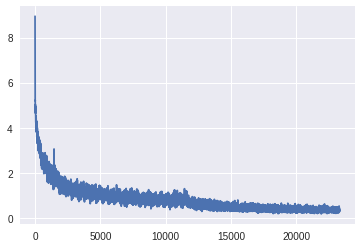

In [23]:
import matplotlib.pyplot as plt
plt.plot(range(0,23300), loss_to_plot)

In [27]:
torch.save(encoder, 'encoder.pkl')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [28]:
torch.save(decoder, 'decoder.pkl')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type Decoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [38]:
from nltk.translate.bleu_score import sentence_bleu
import warnings
warnings.filterwarnings('ignore')

BLEU=0
for i in range(1, len(train_data)+1):
    test = train_data[i-1]
    input_ = test[0]
    truth = test[1]

    output, hidden = encoder(input_, [input_.size(1)])
    pred, attn = decoder.decode(hidden, output)

    # input_ = [index_to_source[i] for i in input_.data.tolist()[0]]
    # pred = [index_to_target[i] for i in pred.data.tolist() if i not in [2, 3]]
    # truth = [index_to_target[i] for i in truth.data.tolist()[0] if i not in [2, 3]]

    score = sentence_bleu(truth.data.tolist(), pred.data.tolist())
    BLEU+=score
    if(i%1000==0):
        print('Sentence: ' + str(i)+ ' BLEU: ' + str(BLEU/i) )
print('Corpus BLEU score: ' + str(BLEU/len(train_data)))


Sentence: 1000 BLEU: 0.8089463589460244
Sentence: 2000 BLEU: 0.8087553566816846
Sentence: 3000 BLEU: 0.8106813944707802
Sentence: 4000 BLEU: 0.8110109063248789
Sentence: 5000 BLEU: 0.8091498486388499
Sentence: 6000 BLEU: 0.8092036625592701
Sentence: 7000 BLEU: 0.8099321936884741
Sentence: 8000 BLEU: 0.8093722941136698
Sentence: 9000 BLEU: 0.8093101081693549
Sentence: 10000 BLEU: 0.8098745539685914
Sentence: 11000 BLEU: 0.8104428974074434
Sentence: 12000 BLEU: 0.8099555263038047
Sentence: 13000 BLEU: 0.8096860129858382
Sentence: 14000 BLEU: 0.8094082113401794
Sentence: 15000 BLEU: 0.809225389670784
Sentence: 16000 BLEU: 0.8098027522360507
Sentence: 17000 BLEU: 0.8087779631886087
Sentence: 18000 BLEU: 0.8085321515945479
Sentence: 19000 BLEU: 0.8084839850603237
Sentence: 20000 BLEU: 0.807972266704642
Sentence: 21000 BLEU: 0.8077192318850434
Sentence: 22000 BLEU: 0.8077447692221367
Sentence: 23000 BLEU: 0.807993059190245
Sentence: 24000 BLEU: 0.8081712257161627
Sentence: 25000 BLEU: 0.8082

In [0]:
def show_attention(input_words, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_words, rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

#     show_plot_visdom()
    plt.show()
    plt.close()


Source :  i m not late , am i ?
Truth :  je ne suis pas en retard , n est ce pas ?
Prediction :  je ne suis en en pas , est ce pas ?


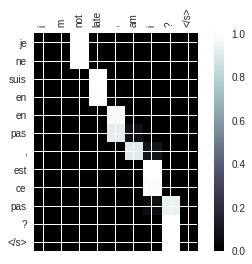

In [37]:
test = random.choice(train_data)
input_ = test[0]
truth = test[1]

output, hidden = encoder(input_, [input_.size(1)])
pred, attn = decoder.decode(hidden, output)

input_ = [index_to_source[i] for i in input_.data.tolist()[0]]
pred = [index_to_target[i] for i in pred.data.tolist()]


print('Source : ',' '.join([i for i in input_ if i not in ['</s>']]))
print('Truth : ',' '.join([index_to_target[i] for i in truth.data.tolist()[0] if i not in [2, 3]]))
print('Prediction : ',' '.join([i for i in pred if i not in ['</s>']]))

if USE_CUDA:
    attn = attn.cpu()

show_attention(input_, pred, attn.data)

In [0]:
app

['il', 'n', 'y', 'a', 'aucun', 'message', '.']